In [6]:
%matplotlib inline
from __future__ import division
import numpy as np
import pandas as pd
import math as maths
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
from scipy.integrate import odeint
from scipy.optimize import minimize as minimise, curve_fit
from decimal import Decimal
from scipy.stats import ttest_rel as ttest

sns.set(style="white", color_codes=True) #, rc= {'figure.facecolor':'palegreen', 'axes.facecolor':'honeydew'}
sns.despine(trim = True)
sns.set_context('poster', font_scale = 1)
sns.set_palette("colorblind", 8) #sns colormap for graph
simga = [100, 0.01, 0.01, 0.01]

# Predicting outcomes of new datasets with the 8-parameter model

Here, the model used in 8_param_system.ipynb is used to predict the changes in epidermal cell types present on the epidermis of two mutant lines: 
- PhyB, which shows a decrease in SI and SD compared to wild type
- Cry1/Cry2, which shows a decrease in SI.

The hypothesis is that the changes in epidermal cell type in the two mutants can be explained in one of two ways:
- decreased stomatal development,
- increased SLGC and PC development.

In the 8-parameter model, this is described by decreasing K0 and k1 or increasing k3 and k4 respectively.

So, beginning with the parameters derived from the CYCD3;1 mock-treated line as a WT baseline, parameters are increased or decreased using the function 'param_change', and the resultant model output is compared to the actual data.

In [15]:
timespan = np.linspace(0,72,100) #timespan of the model (0 - 72 hours, with 1000 timepoints)
timepoints = [0, 24, 48, 72] #actual timepoints in hours of the data
sigma = [100, 0.00001, 0.00001, 0.00001] #weighting to ensure fitting includes 
                                        #first data point for more accurate fitting
parameters1 = np.array((0.03115,0.031634,0,0,0.00243,0.000898,0.005832,0)) #initial WT parameters

In [16]:
def diffeq(y, t, k0, k1, k2, k3, k4, k5, k6, k7):

    ''' 
    Function containing the ODEs for the model system:
    inputs:
        y - array of initial cell numbers in form [mc, gmc, stm, slgc, pc]
        t - time over which the function runs (not necessary for the equation, but is for integration with odeint)
        k0, k1, k2, k3, k4, k5, k6 - float, parameter values
    '''

    MCi = y[0]
    GMCi = y[1]
    STMi = y[2]
    SLGCi = y[3]
    PCi = y[4]
    #the model equations =
    f0 = (k5*SLGCi)-((k0+k2)*MCi)+(k7*GMCi)
    f1 = (k0*MCi)-((k1+k7)*GMCi)
    f2 = (k1*GMCi)
    f3 = ((k2*MCi)-((k5+k3)*SLGCi)+ k6*PCi)
    f4 = (k3*SLGCi) + ((k4-k6)*PCi) 
    
    return [f0, f1, f2, f3, f4]


In [17]:
def diffeqsolver(y1, t1, parameters1):

    '''
    function which passes the input from func to odeint
    inputs:
        y1 - array of initial cell numbers in form [mc, gmc, stm, slgc, pc]
        t1 - time for diffeq solver
        parameters - list of parameters to be fed to diffeqs
    '''

    parameters_tuple = tuple(parameters1)
    
    soln = odeint(diffeq, y1, t1, args = parameters_tuple)
    MC = soln[:, 0]
    GMC = soln[:, 1]
    STM = soln[:, 2]
    SLGC = soln[:, 3]
    PC = soln[:, 4]

    return [MC, GMC, STM, SLGC, PC]

In [18]:
def param_fitter(cell_counts, initial_guess):
    '''
    function to pass data through scipy.minimize (here named minimise)
    input:
        - cell counts at t0
        - initial guess of parameter values
        
    output:
        - scipy.minimise object attribute .x, which is the minimised parameter values.
    '''
    initial_guess = initial_guess
    def minimiser(params1):

        '''function to be minimised by the scipy minimiser.
        accepts only params, an array of the first guesses for each parameter.

        outputs the regression for the fit between a line of best fit and the model.'''

        xlist = cell_counts #cell type to be fitted to
        y1 = xlist[:,0]

        y = diffeqsolver(y1, timespan, params1)
        minval = np.zeros(len(xlist))  
        for x in range(len(xlist)):
            
            curve = np.polyfit([0, 24, 48, 72],xlist[x], 1)#, w = sigma) #fit cell counts from data to a curve for linregress

            x2 = np.polyval(curve, timespan) #evaluate curve over timecourse

            y0 = y[x] #values from integrated ode over time

            ss=lambda data,model:((data-model)**2).sum()
            minval[x] = ss(x2, y0)
            
        return minval.sum()
    
    solution = minimise(minimiser, initial_guess, bounds = 
                        ((0, None),(0, None),(0, None),
                         (0, None),(0, None),(0, None),(0, None),(0,None)))
    

    return solution.x



In [19]:
def parameter_change(param_change, parameters):
    new_parameters = parameters
    for i in range(len(parameters)):

        p = parameters[i]
        x = param_change[i]
        
        new_p = p*x
        new_parameters[i] = new_p


    return new_parameters

## Data Wrangling

In [20]:
'''
iterate over all the conditions in the dataframe, extract the count values at each timepoint and fit the parameters of diffeq to 
the line of best fit to those values over time.

generates a dictionary:
    -param_dict[background, condition] =  [fitted parameter values]
'''


file_name = 'cell_population_counts_Col0_Mute_SPCH.xlsx'
dfPhyB = pd.read_excel(open(file_name,'rb'), sheetname='Sheet1') #make pandas dataframe from spreadsheet
cond_dict = {} #used to extract data from dataframe for ease of manipulation

conditions_dict = {}  #used to put data into format required for odeint solver.

conditions_list = list(itertools.product(dfPhyB.background.unique(),
                                    dfPhyB.time.unique())) #list of all growth conditions in the dataframe

for b,t in conditions_list:
    '''
    sorts dataframe into dictionary, cond_dict, where:
    cond_dict[genotype, timepoint] = [SPCs, Stomata, SLGCs, PCs]
    '''
    conditionPD = dfPhyB[(dfPhyB.background == b)&(dfPhyB.time == t)]
    
    avgarea = np.nanmean(conditionPD.avg_cell_area.values)

    
    cond_dict[b,t]=np.asarray([
       (np.nanmean(conditionPD.MC.values)*avgarea),
        (np.nanmean(conditionPD.GMC.values)* avgarea),
       (np.nanmean(conditionPD.Stomata.values)* avgarea),
        (np.nanmean(conditionPD.SLGC.values)* avgarea),
        (np.nanmean(conditionPD.PC.values)* avgarea)])

for b in dfPhyB.background.unique():
    '''
    sorts dataframe into dictionary, conditions_dict, where:
    cond_dict[genotyp] = [[SPCs at t0,..., SPCs at tn],
                          [Stomata at t0,..., Stomata at tn],
                          [SLGCs at t0,..., SLGCs at tn],
                          [PCs at t0,..., PCs at tn]]
    for feeding into scipy.odeint.
    '''
    
    MCS = [cond_dict[b,  t][0] for t in dfPhyB.time.unique()]
    GMCS = [cond_dict[b,  t][1] for t in dfPhyB.time.unique()]
    STMS = [cond_dict[b,  t][2] for t in dfPhyB.time.unique()]
    SLGCS = [cond_dict[b,  t][3] for t in dfPhyB.time.unique()]
    PCS = [cond_dict[b,  t][4] for t in dfPhyB.time.unique()]
    
    conditions_dict[b] = [MCS, GMCS, STMS, SLGCS, PCS]
    
cell_counts = np.asarray(conditions_dict['PhyB']) #convert list to array for easy slicing

cell_counts[:, 1] #verify correct data wrangling

array([ 0.02993994,  0.03742493,  0.21706458,  0.6699062 ,  0.06175113])

## Plot actual data for comparison to model output

- saves image for each genotype, b, in the form 'data_lobf_b.svg'

0    0.170609
1    0.061751
2    0.138205
3    0.083436
Name: PC, dtype: float64
0    0.149347
1    0.079259
2    0.115594
3    0.071292
Name: PC, dtype: float64


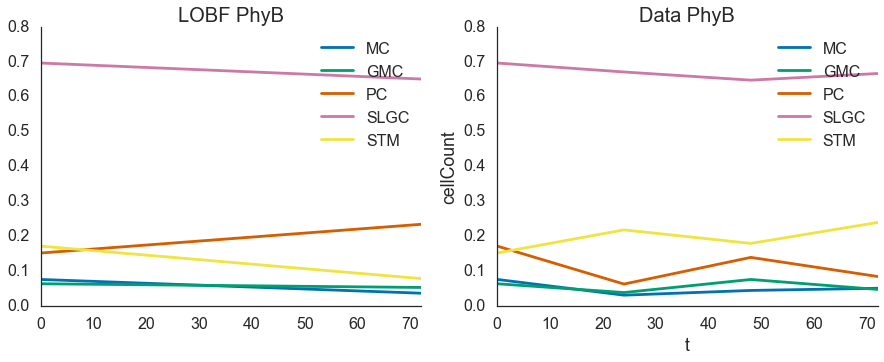

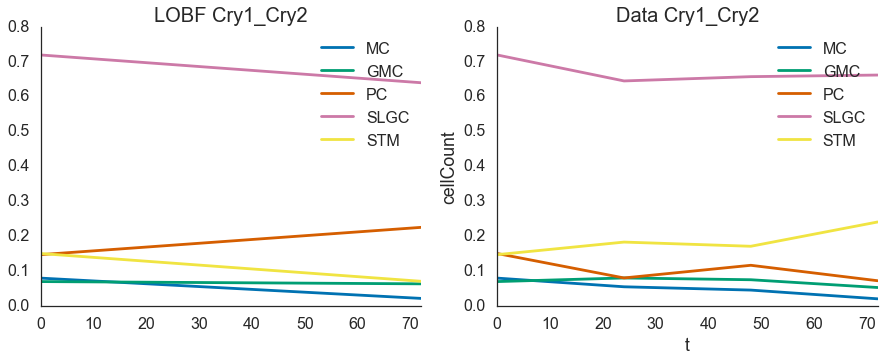

In [21]:
for b in dfPhyB.background.unique():
    fig = plt.figure(figsize=(15,5))
    cell_counts = np.asarray(conditions_dict[b])
    
    
    '''actual data from excel spreadsheet '''
    axs1 = fig.add_subplot(1, 2, 2)
    dataDf = pd.DataFrame({'time': timepoints, 
                              'MC' : cell_counts[0, :],
                              'GMC' : cell_counts[1,:],
                              'STM' : cell_counts[2, :],
                              'SLGC' : cell_counts[3, :],
                              'PC': cell_counts[4, :]})
    print(dataDf.PC)
    dataDf.plot(x = 'time', y = ['MC','GMC', 'PC', 'SLGC', 'STM'],ax=axs1)
    axs1.set_xlabel('t')
    axs1.set_ylabel('cellCount')
    axs1.set_ylim(0, 0.8)
    axs1.set_title('Data '+b, fontsize = 20)

    ''' lobf for data'''
    axs2 = fig.add_subplot(1, 2, 1)
    namelist = ['MC','GMC', 'PC', 'SLGC', 'STM']
    time = [0, 24, 48, 72]  
    curve_dict = {}
    for n in range(len(cell_counts[:,0])):

        curve = np.polyfit(time ,cell_counts[n], 1, w=sigma)
        x2 = np.polyval(curve, timespan)
        curve_dict[namelist[n]] = x2
    fit_df = pd.DataFrame.from_dict(curve_dict)
    fit_df.plot(x = timespan, y = ['MC','GMC', 'PC', 'SLGC', 'STM'],ax=axs2)
    axs2.set_title('LOBF '+b, fontsize = 20)
    axs2.set_ylim(0, 0.8)

    axs1.legend(bbox_to_anchor=(.70, 1), loc=2)
    axs2.legend(bbox_to_anchor=(.70, 1), loc=2)
    sns.despine()
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig('data_lobf_'+b+'.svg')

# Simulation with WT parameters

an initial run of the simulation with the WT parameters.

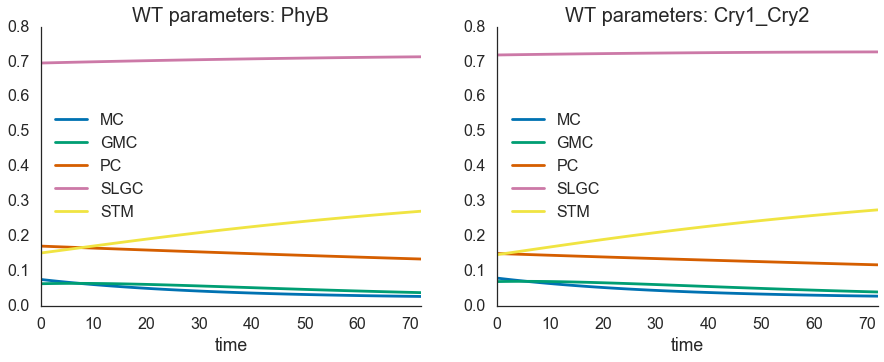

In [24]:
tSTM = np.linspace(0, 72, 100) #timecourse for the integrator
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
axes = (ax1, ax2)
axval = 0

for b in dfPhyB.background.unique():
    
    cell_counts = np.asarray(conditions_dict[b])
    soln = odeint(diffeq, cell_counts[:,0], tSTM, args = tuple(parameters1)) #integrate diffeqs 
    MC = soln[:, 0]
    GMC = soln[:,1]
    STM = soln[:, 2]
    SLGC = soln[:, 3]
    PC = soln[:, 4]
    solutions = [MC, GMC, STM, SLGC, PC]

    resultsDf = pd.DataFrame({'time': tSTM, 'MC' : MC,'GMC' : GMC, 'PC' : PC, 'SLGC' : SLGC,'STM':STM})
    
    
    resultsDf.plot(x = 'time', y = ['MC','GMC','PC','SLGC','STM'], ax = axes[axval])
    axes[axval].set_title('WT parameters: '+ b, fontsize = 20)
    #axes[axval].set_ylim(0, 0.8)
    sns.despine()
    axval += 1
plt.savefig('no_change_in_params.svg')

# Decreasing k0

using the parameter_change function to decrease k0 by 90% and run simulation.
Saves output as decrease_params.svg

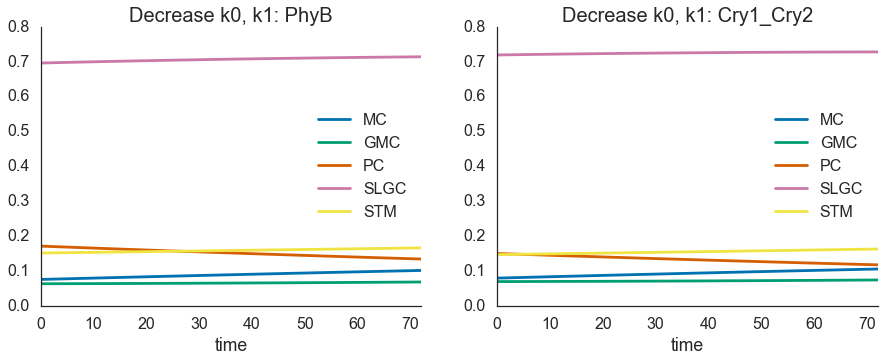

In [28]:
param_change_Cry1 = [0.1, 0.1, 1, 1, 1, 1,1, 1]
param_change_phyB = [0.1, 0.1, 1, 1, 1, 1,1, 1]

params_list = [param_change_Cry1, param_change_phyB]

tSTM = np.linspace(0, 72, 100) #timecourse for the integrator
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
axes = (ax1, ax2)
axval = 0

for i in range(len(params_list)):

    b = dfPhyB.background.unique()[i]
    parameters1 = np.array((0.03115,0.031634,0,0,0.00243,0.000898,0.005832,0))
    changed_params = parameter_change(params_list[i], parameters1)
    parameters1 = np.array((0.03115,0.031634,0,0,0.00243,0.000898,0.005832,0))
    cell_counts = np.asarray(conditions_dict[b])
    soln = odeint(diffeq, cell_counts[:,0], tSTM, args = tuple(changed_params)) #integrate diffeqs 
    MC = soln[:, 0]
    GMC = soln[:, 1]
    STM = soln[:,2]
    SLGC = soln[:, 3]
    PC = soln[:, 4]
    solutions = [MC,GMC, STM, SLGC, PC]

    resultsDf = pd.DataFrame({'time': tSTM, 'MC' : MC,'GMC' : GMC, 'PC' : PC, 'SLGC' : SLGC,'STM':STM})
    
    resultsDf.plot(x = 'time', y = ['MC','GMC','PC','SLGC','STM'], ax = axes[axval])
    axes[axval].set_title('Decrease k0, k1: '+ b, fontsize = 20)
    #axes[axval].set_ylim(0, 0.8)
    sns.despine()
    axval += 1
plt.savefig('decrease_in_8_params.svg')
    

# Increasing k3, k4

using the parameter_change function to increase k5 by 90% and run simulation.

saves as increase_k5.svg

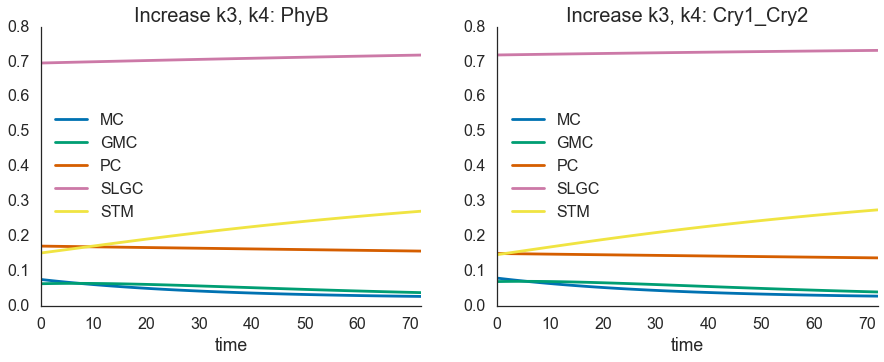

In [29]:
param_change_Cry1 = [1, 1, 1, 1.9, 1.9, 1, 1, 1]
param_change_phyB = [1, 1, 1, 1.9, 1.9, 1, 1, 1]

params_list = [param_change_Cry1, param_change_phyB]

tSTM = np.linspace(0, 72, 100) #timecourse for the integrator
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
axes = (ax1, ax2)
axval = 0

for i in range(len(params_list)):

    b = dfPhyB.background.unique()[i]
    parameters1 = np.array((0.03115,0.031634,0,0,0.00243,0.000898,0.005832,0))
    changed_params = parameter_change(params_list[i], parameters1)
    parameters1 = np.array((0.03115,0.031634,0,0,0.00243,0.000898,0.005832,0))
    cell_counts = np.asarray(conditions_dict[b])
    soln = odeint(diffeq, cell_counts[:,0], tSTM, args = tuple(changed_params)) #integrate diffeqs 
    MC = soln[:, 0]
    GMC = soln[:, 1]
    STM = soln[:,2]
    SLGC = soln[:, 3]
    PC = soln[:, 4]
    solutions = [MC,GMC, STM, SLGC, PC]

    resultsDf = pd.DataFrame({'time': tSTM, 'MC' : MC,'GMC' : GMC, 'PC' : PC, 'SLGC' : SLGC,'STM':STM})
    
    resultsDf.plot(x = 'time', y = ['MC','GMC','PC','SLGC','STM'], ax = axes[axval])
    axes[axval].set_title('Increase k3, k4: '+ b, fontsize = 20)
    #axes[axval].set_ylim(0, 0.8)
    sns.despine()
    axval += 1
    
plt.savefig('increase_in_8_params.svg')